# Importing necessary libraries

In [1]:
from nltk import WordNetLemmatizer, word_tokenize, sent_tokenize, ngrams, FreqDist
from nltk.corpus import stopwords
import re
import string
import numpy as np
import random
import matplotlib.pyplot as plt

### Load our corpus from Sherlock Holmes 

In [2]:
path = 'advs.txt'
with open(path, 'r', encoding='utf-8') as file:
    data = file.read()
data

'\n\n\n\n                        THE ADVENTURES OF SHERLOCK HOLMES\n\n                               Arthur Conan Doyle\n\n\n\n                                Table of contents\n\n               A Scandal in Bohemia\n               The Red-Headed League\n               A Case of Identity\n               The Boscombe Valley Mystery\n               The Five Orange Pips\n               The Man with the Twisted Lip\n               The Adventure of the Blue Carbuncle\n               The Adventure of the Speckled Band\n               The Adventure of the Engineer\'s Thumb\n               The Adventure of the Noble Bachelor\n               The Adventure of the Beryl Coronet\n               The Adventure of the Copper Beeches\n\n\n\n\n\n\n\n\n\n\n                              A SCANDAL IN BOHEMIA\n\n\n\n\n\n                                Table of contents\n                                     Chapter 1\n                                     Chapter 2\n                                     Chapt

### Export sentences from our corpus to have more effient model for skip-gram and better intution of window size

### Example to be certain of sentence tokenizer

In [3]:
text = 'Dr.Khosravi have some briliant ideas. avenue st. has very complex road.'
sentences = sent_tokenize(text)
for sentence in sentences:
    print(sentence)

Dr.Khosravi have some briliant ideas.
avenue st. has very complex road.


### Before tokenize data with sentences
1.  clear '\n' in data
2.  clear whitespaces

In [4]:
data = data.replace('\n', '')
data = re.sub(r'\s+', ' ', data).strip()
data

'THE ADVENTURES OF SHERLOCK HOLMES Arthur Conan Doyle Table of contents A Scandal in Bohemia The Red-Headed League A Case of Identity The Boscombe Valley Mystery The Five Orange Pips The Man with the Twisted Lip The Adventure of the Blue Carbuncle The Adventure of the Speckled Band The Adventure of the Engineer\'s Thumb The Adventure of the Noble Bachelor The Adventure of the Beryl Coronet The Adventure of the Copper Beeches A SCANDAL IN BOHEMIA Table of contents Chapter 1 Chapter 2 Chapter 3 CHAPTER I To Sherlock Holmes she is always the woman. I have seldom heard him mention her under any other name. In his eyes she eclipses and predominates the whole of her sex. It was not that he felt any emotion akin to love for Irene Adler. All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false positi

In [5]:
sentences = sent_tokenize(data)
for sentence in sentences:
    print(sentence)

THE ADVENTURES OF SHERLOCK HOLMES Arthur Conan Doyle Table of contents A Scandal in Bohemia The Red-Headed League A Case of Identity The Boscombe Valley Mystery The Five Orange Pips The Man with the Twisted Lip The Adventure of the Blue Carbuncle The Adventure of the Speckled Band The Adventure of the Engineer's Thumb The Adventure of the Noble Bachelor The Adventure of the Beryl Coronet The Adventure of the Copper Beeches A SCANDAL IN BOHEMIA Table of contents Chapter 1 Chapter 2 Chapter 3 CHAPTER I To Sherlock Holmes she is always the woman.
I have seldom heard him mention her under any other name.
In his eyes she eclipses and predominates the whole of her sex.
It was not that he felt any emotion akin to love for Irene Adler.
All emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind.
He was, I take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position

In [6]:
# stop_words = set(stopwords.words('english'))
def preprocessing(sentence):
    my_sentence = sentence
    tokens = word_tokenize(my_sentence)
    tokens = [token.lower() for token in tokens]
    tokens = [word for word in tokens if word not in string.punctuation]
    # tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    tokens = [token for token in tokens if token not in {"r's", "e's", "r", "e", "g", "p"}]
    return tokens

In [7]:
tokens = [preprocessing(sentence) for sentence in sentences]

print(sentences[2], tokens[2])

In his eyes she eclipses and predominates the whole of her sex. ['in', 'his', 'eye', 'she', 'eclipse', 'and', 'predominates', 'the', 'whole', 'of', 'her', 'sex']


In [8]:
def assign_neighbors(tokenized_sentence, window_size=2):
    word_neighbors = {}
    for tokens in tokenized_sentence:
        for i, word in enumerate(tokens):
            start = max(0, i-window_size)
            end = min(len(tokens), i + window_size + 1)
            neighbors = set(tokens[start:i] + tokens[i+1:end])
            if word not in word_neighbors:
                word_neighbors[word] = set()
            word_neighbors[word].update(neighbors)
    return word_neighbors

In [9]:
context_neigbor = assign_neighbors(tokens, window_size=5)
context_neigbor

{'the': {'hedge',
  'willingly',
  'appear',
  'observed',
  'derived',
  'depositor',
  'untimely',
  'ignorant',
  'coronet',
  'sleeper',
  'rearing',
  'remember',
  'threatens',
  'kick',
  'play',
  'jagged',
  'harness',
  'tray',
  'dig',
  'tobacconist',
  'gasogene',
  'digging',
  'here',
  'blue',
  'promptly',
  'thought',
  'inquired',
  'wimpole',
  'confession',
  'impressed',
  'postpone',
  'tower',
  'direction',
  'advantage',
  'answer',
  'clergyman',
  'vacuous',
  'countess',
  'longed',
  'spend',
  'nothing',
  'province',
  'meadow',
  'handed',
  'indignation',
  'trincomalee',
  'clothes',
  'older',
  'steaming',
  'gossip',
  'waned',
  'setting',
  'parcel',
  'offence',
  'motionless',
  'blacksmith',
  'steamed',
  'company',
  'burnished',
  'rubbing',
  'awakened',
  'godfrey',
  'programme',
  'everyone',
  'quiet',
  'occurred',
  'shock',
  'shriek',
  'web',
  'greenwich',
  'existence',
  'wire',
  'individuality',
  'contortion',
  'terraced',


In [10]:
context_neigbor['queen']

{'a', 'admirable', 'an', 'have', 'made', 'not', 'she', 'what', 'would'}

### Unigram and FreqDist for them for negative sampling

In [11]:
whole_tokens = []
for token_list in tokens:
    whole_tokens.extend(token_list)

In [12]:
unigram = list(ngrams(whole_tokens, 1))
uni_freq = FreqDist(unigram)
uni_freq

FreqDist({('the',): 5615, ('a',): 3494, ('i',): 3035, ('and',): 2994, ('to',): 2685, ('of',): 2659, ('it',): 1809, ('in',): 1761, ('that',): 1743, ('he',): 1482, ...})

### Applying $\alpha$ count to frequencies

In [13]:
alpha = 0.75
total_freqs = np.sum(np.array([value**alpha for _,value in uni_freq.items()]))
for key,value in uni_freq.items():
    uni_freq[key] = (uni_freq[key] ** alpha) / total_freqs
weighted_probs = [value for _,value in uni_freq.items()]
unique_words = [key[0] for key,_ in uni_freq.items()]

### Negative sampling
1.  First make pairs of each target and poisitive context
2.  For each pair get 4 negative samples

In [14]:
target_neighbors_pairs = []
for target_index, neighbors in context_neigbor.items():
    pairs = [(target_index, neighbor) for neighbor in neighbors]
    target_neighbors_pairs.extend(pairs)
target_neighbors_pairs

[('the', 'hedge'),
 ('the', 'willingly'),
 ('the', 'appear'),
 ('the', 'observed'),
 ('the', 'derived'),
 ('the', 'depositor'),
 ('the', 'untimely'),
 ('the', 'ignorant'),
 ('the', 'coronet'),
 ('the', 'sleeper'),
 ('the', 'rearing'),
 ('the', 'remember'),
 ('the', 'threatens'),
 ('the', 'kick'),
 ('the', 'play'),
 ('the', 'jagged'),
 ('the', 'harness'),
 ('the', 'tray'),
 ('the', 'dig'),
 ('the', 'tobacconist'),
 ('the', 'gasogene'),
 ('the', 'digging'),
 ('the', 'here'),
 ('the', 'blue'),
 ('the', 'promptly'),
 ('the', 'thought'),
 ('the', 'inquired'),
 ('the', 'wimpole'),
 ('the', 'confession'),
 ('the', 'impressed'),
 ('the', 'postpone'),
 ('the', 'tower'),
 ('the', 'direction'),
 ('the', 'advantage'),
 ('the', 'answer'),
 ('the', 'clergyman'),
 ('the', 'vacuous'),
 ('the', 'countess'),
 ('the', 'longed'),
 ('the', 'spend'),
 ('the', 'nothing'),
 ('the', 'province'),
 ('the', 'meadow'),
 ('the', 'handed'),
 ('the', 'indignation'),
 ('the', 'trincomalee'),
 ('the', 'clothes'),
 ('th

In [15]:
def get_negative_samples(pairs, context_neigbor, unique_words, weighted_probs, n_samples=4):
    target_neigbor = list(context_neigbor[pairs[0]]) + list(context_neigbor[pairs[1]])
    negative_samples = []
    while len(negative_samples) < n_samples:
        neg_candidates = random.choices(unique_words, weighted_probs, k=n_samples)
        for neg in neg_candidates:
            if neg not in target_neigbor + [pairs[0]] + negative_samples + [pairs[1]]:
                negative_samples.append(neg)
            if len(negative_samples) == n_samples:
                break
    return negative_samples

In [16]:
negative_samples = {pair: get_negative_samples(pair, context_neigbor, unique_words, weighted_probs) for pair in target_neighbors_pairs}
negative_samples

{('the', 'hedge'): ['pitiable', 'holborn', 'inscrutable', 'intruding'],
 ('the', 'willingly'): ['sparkle', 'penetrating', 'millionaire', 'unsolved'],
 ('the', 'appear'): ['nice', 'observant', 'yourselves', 'insist'],
 ('the', 'observed'): ['jollification', 'anyhow', 'prima', 'chap'],
 ('the', 'derived'): ['haggard', 'majesty', 'abnormally', 'eager'],
 ('the', 'depositor'): ['plucked', 'roused', 'suffered', 'footing'],
 ('the', 'untimely'): ['ado', 'restored', 'facility', 'prey'],
 ('the', 'ignorant'): ['ascertain', 'compliance', 'noted', 'describes'],
 ('the', 'coronet'): ['gripping', 'lassitude', 'affectionate', 'lecture'],
 ('the', 'sleeper'): ['holborn', 'laudanum', 'thinness', 'advise'],
 ('the', 'rearing'): ['perplexity', 'prefer', 'whoa', 'cumbrous'],
 ('the', 'remember'): ['de', 'thursday', 'childish', 'tie'],
 ('the', 'threatens'): ['gilt', 'identical', 'disconnected', 'ridiculously'],
 ('the', 'kick'): ['prima', 'annual', 'abrupt', 'proceed'],
 ('the', 'play'): ['frogged', 'co

In [17]:
negative_samples[('sherlock', 'holmes')]

['eventually', 'circulation', 'same', 'incarnate']

In [18]:
class skip_gram():
    def __init__(self, unique_words, embedding_dim, contexts) -> None:
        self.unique_words = unique_words
        self.embedding_dim = embedding_dim
        self.neighbors_neg_context = list(contexts.items())
        self.lr = None
        self.loss = None
        self.context_matrix = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, (len(unique_words), embedding_dim))
        self.target_matrix = np.random.uniform(-0.5/embedding_dim, 0.5/embedding_dim, (len(unique_words), embedding_dim))

    def fit(self, learning_rate, epochs):
        loss_per_epoch = np.zeros(shape=(epochs))
        self.lr = learning_rate
        for epoch in range(epochs):
            self.loss = 0
            random.shuffle(self.neighbors_neg_context)
            for pair, negative_samples in self.neighbors_neg_context:
                self._update_weights_with_loss(pair, negative_samples)
            print(f'Epoch number : {epoch}, Loss : {self.loss}')
            loss_per_epoch[epoch] = self.loss
        return loss_per_epoch
    
    def _update_weights_with_loss(self, pair, negative_samples):
        cache = 0

        target_index, context_index = self.unique_words.index(pair[0]), self.unique_words.index(pair[1])
        dot_product = np.dot(self.context_matrix[context_index, :], self.target_matrix[target_index, :])
        sigmoid_score = self._sigmoid_function(dot_product)
        self.loss -= (np.log(sigmoid_score))
        cache += ((sigmoid_score-1) * self.context_matrix[context_index, :])
        self.context_matrix[context_index, :] -= (self.lr * (sigmoid_score - 1) * self.target_matrix[target_index, :])

        for neg_sample in negative_samples:
            word_index = self.unique_words.index(neg_sample)
            dot_product = np.dot(self.context_matrix[word_index, :], self.target_matrix[target_index, :])
            self.loss -= (np.log(self._sigmoid_function(-dot_product)))
            sigmoid_score = self._sigmoid_function(dot_product)
            cache += (sigmoid_score * self.context_matrix[word_index, :])
            self.context_matrix[word_index, :] -= (self.lr * (sigmoid_score) * self.target_matrix[target_index, :])
        self.target_matrix[target_index, :] -= (self.lr * cache)
    
    def _sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def matrix_sums(self):
        return self.context_matrix + self.target_matrix
    
    def cosine_between_two_vec(self, x, y):
        return np.dot(x,y)/ np.sqrt(np.dot(x,x)*np.dot(y,y))

In [35]:
embedding_dim = 100
model = skip_gram(unique_words, embedding_dim, negative_samples)

In [36]:
learning_rate = 0.05
epochs = 20
loss_per_epoch = model.fit(learning_rate, epochs)

Epoch number : 0, Loss : 968797.4204885232
Epoch number : 1, Loss : 672681.3626032851
Epoch number : 2, Loss : 579250.6894419065
Epoch number : 3, Loss : 512007.4715105867
Epoch number : 4, Loss : 446017.3934610567
Epoch number : 5, Loss : 376559.37062855245
Epoch number : 6, Loss : 309391.1215425612
Epoch number : 7, Loss : 248279.04157097853
Epoch number : 8, Loss : 195997.5580741992
Epoch number : 9, Loss : 153640.12211872436
Epoch number : 10, Loss : 119907.56697581666
Epoch number : 11, Loss : 92968.19918299916
Epoch number : 12, Loss : 71786.09402873224
Epoch number : 13, Loss : 55373.19429101373
Epoch number : 14, Loss : 42876.9160522699
Epoch number : 15, Loss : 33549.9481875205
Epoch number : 16, Loss : 26897.043260059232
Epoch number : 17, Loss : 22186.56858114025
Epoch number : 18, Loss : 18785.040611545483
Epoch number : 19, Loss : 16246.449352124142


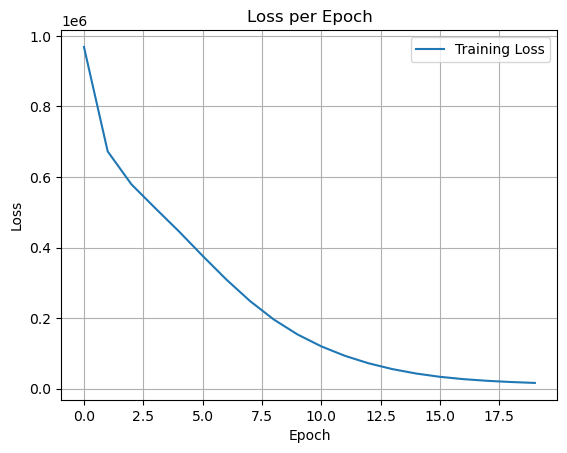

In [37]:
plt.plot(loss_per_epoch, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
embedding_vectors = model.matrix_sums()

In [52]:
king_index = unique_words.index('king')
man_index = unique_words.index('he')
woman_index = unique_words.index('she')
queen_index = unique_words.index('queen')
print(king_index, man_index, woman_index, queen_index)

859 67 42 1689


In [53]:
vec_1 = embedding_vectors[king_index, :] - embedding_vectors[man_index, :] + embedding_vectors[woman_index, :]
vec_2 = embedding_vectors[queen_index, :]
cosin_vec1_vec2 = model.cosine_between_two_vec(vec_1, vec_2)
cosin_vec1_vec2

0.24493249387823074

In [41]:
vec_1 = embedding_vectors[unique_words.index('sherlock')]
vec_2 = embedding_vectors[unique_words.index('holmes')]
cosin_vec1_vec2 = model.cosine_between_two_vec(vec_1, vec_2)
cosin_vec1_vec2

0.6911999937653254

In [42]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_vectors)

In [48]:
word1_index = unique_words.index('sister')
word2_index = unique_words.index('brother')
word3_index = unique_words.index('aunt')
word4_index = unique_words.index('uncle')
word1_embedding_2d = embeddings_2d[word1_index]
word2_embedding_2d = embeddings_2d[word2_index]
word3_embedding_2d = embeddings_2d[word3_index]
word4_embedding_2d = embeddings_2d[word4_index]

In [54]:
diff_vector_2d = word2_embedding_2d - word1_embedding_2d
diff_vector_2d_2 = word4_embedding_2d - word3_embedding_2d

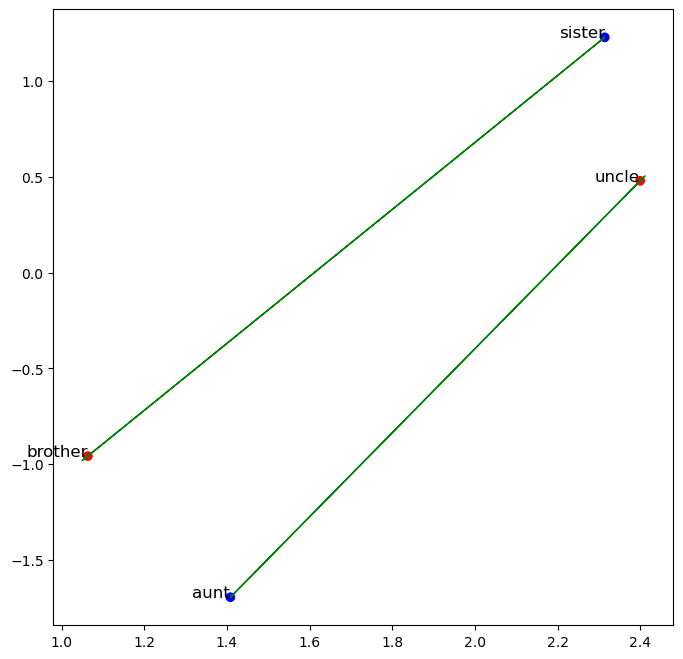

In [56]:
plt.figure(figsize=(8, 8))

plt.scatter([word2_embedding_2d[0], word1_embedding_2d[0]], [word2_embedding_2d[1], word1_embedding_2d[1]], color=['red', 'blue'])
plt.scatter([word4_embedding_2d[0], word3_embedding_2d[0]], [word4_embedding_2d[1], word3_embedding_2d[1]], color=['red', 'blue'])
plt.text(word1_embedding_2d[0], word1_embedding_2d[1], 'sister', fontsize=12, ha='right')
plt.text(word2_embedding_2d[0], word2_embedding_2d[1], 'brother', fontsize=12, ha='right')
plt.text(word3_embedding_2d[0], word3_embedding_2d[1], 'aunt', fontsize=12, ha='right')
plt.text(word4_embedding_2d[0], word4_embedding_2d[1], 'uncle', fontsize=12, ha='right')

plt.arrow(word1_embedding_2d[0], word1_embedding_2d[1], diff_vector_2d[0], diff_vector_2d[1], head_width=0.005, head_length=0.03, fc='green', ec='green')
plt.arrow(word3_embedding_2d[0], word3_embedding_2d[1], diff_vector_2d_2[0], diff_vector_2d_2[1], head_width=0.005, head_length=0.03, fc='green', ec='green')


plt.show()


In [57]:
print(model.cosine_between_two_vec(diff_vector_2d, diff_vector_2d_2))

-0.9957991299992963


In [59]:
vec_1 = embedding_vectors[word2_index, :] - embedding_vectors[word1_index, :]
vec_2 = embedding_vectors[word4_index, :] - embedding_vectors[word3_index, :]
print(model.cosine_between_two_vec(vec_1, vec_2))

-0.04444874156045406
